In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Explore data

In [14]:
data = pd.read_csv("nasa.csv", parse_dates=["Orbit Determination Date", "Close Approach Date"], dayfirst=True)
data.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [15]:
data.isna().sum()

Neo Reference ID                0
Name                            0
Absolute Magnitude              0
Est Dia in KM(min)              0
Est Dia in KM(max)              0
Est Dia in M(min)               0
Est Dia in M(max)               0
Est Dia in Miles(min)           0
Est Dia in Miles(max)           0
Est Dia in Feet(min)            0
Est Dia in Feet(max)            0
Close Approach Date             0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Relative Velocity km per hr     0
Miles per hour                  0
Miss Dist.(Astronomical)        0
Miss Dist.(lunar)               0
Miss Dist.(kilometers)          0
Miss Dist.(miles)               0
Orbiting Body                   0
Orbit ID                        0
Orbit Determination Date        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis                 0
Inclination   

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Neo Reference ID              4687 non-null   int64         
 1   Name                          4687 non-null   int64         
 2   Absolute Magnitude            4687 non-null   float64       
 3   Est Dia in KM(min)            4687 non-null   float64       
 4   Est Dia in KM(max)            4687 non-null   float64       
 5   Est Dia in M(min)             4687 non-null   float64       
 6   Est Dia in M(max)             4687 non-null   float64       
 7   Est Dia in Miles(min)         4687 non-null   float64       
 8   Est Dia in Miles(max)         4687 non-null   float64       
 9   Est Dia in Feet(min)          4687 non-null   float64       
 10  Est Dia in Feet(max)          4687 non-null   float64       
 11  Close Approach Date           

In [17]:
data.shape

(4687, 40)

# Feature Engineering

## Remove columns

In [18]:
remove_columns = [
    # Chose a different measurement unit
    "Est Dia in M(min)", 
    "Est Dia in M(max)", 
    "Est Dia in Miles(min)", 
    "Est Dia in Miles(max)", 
    "Est Dia in Feet(min)", 
    "Est Dia in Feet(max)",
    "Miles per hour",
    "Relative Velocity km per sec",
    "Miss Dist.(Astronomical)",
    "Miss Dist.(lunar)", 
    "Miss Dist.(miles)",
    # Same value for all rows
    "Equinox", 
    "Orbiting Body",
    # Requires further data to be useful
    "Orbit ID",
    "Name",
    # Not relevant
    "Neo Reference ID",
    "Orbit Determination Date",
    "Close Approach Date",
    "Epoch Date Close Approach",
    # Based on correlation analysis
    # "Absolute Magnitude",
    # "Orbit Uncertainity", 
    # "Minimum Orbit Intersection"
]
keep_columns = [col for col in data.columns.tolist() if col not in remove_columns]
data = data[keep_columns]

In [19]:
print(f"{keep_columns}\n{len(keep_columns)} columns")

['Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Relative Velocity km per hr', 'Miss Dist.(kilometers)', 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 'Eccentricity', 'Semi Major Axis', 'Inclination', 'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance', 'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion', 'Hazardous']
21 columns


In [20]:
# Parameters for the upcoming visualisations
# Without label
cols = list(keep_columns)[:-1]
num_cols = 4
num_rows = 6

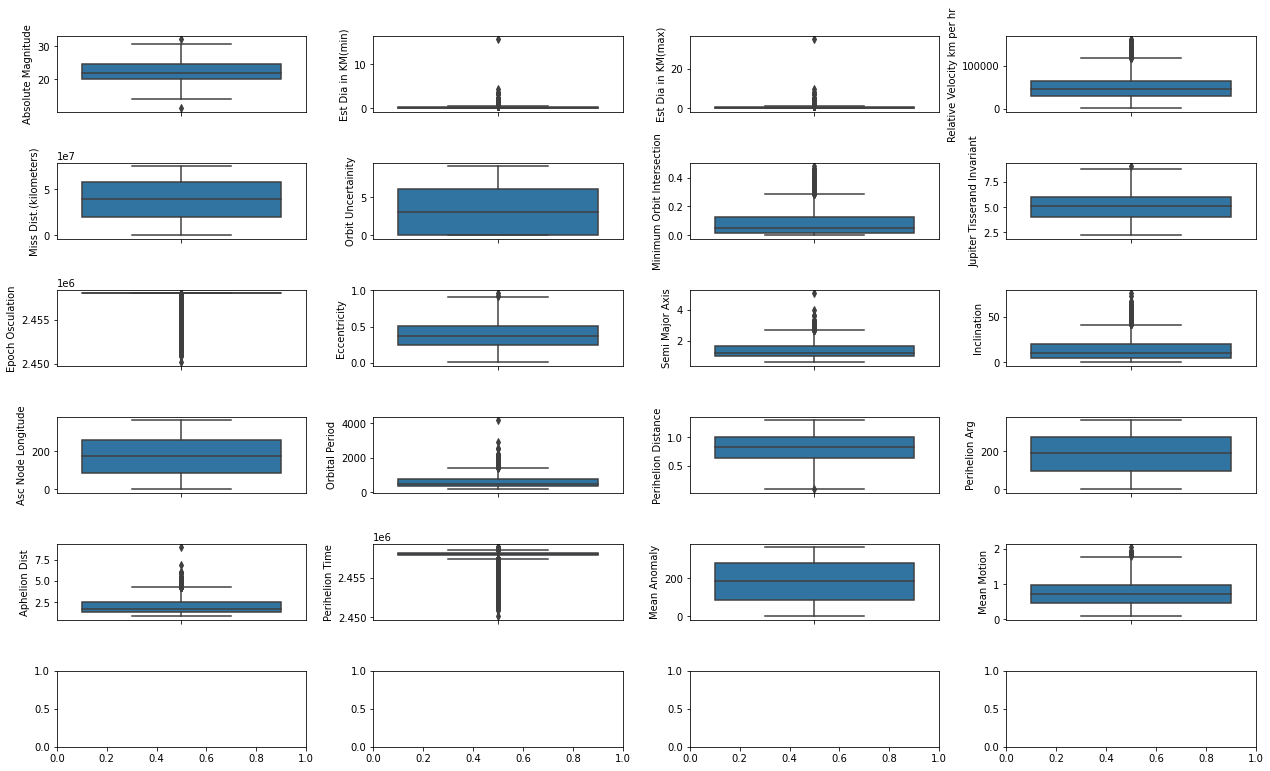

In [21]:
# Visualise outliers with boxplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 11))
fig.tight_layout(pad=3.0)
for i in range(len(cols)):
    # Calculate in which matrix coordinate to draw the next plot
    matrix_coord = axes[i//num_cols, i%num_cols]
    sns.boxplot(ax=matrix_coord, y=data[cols[i]])

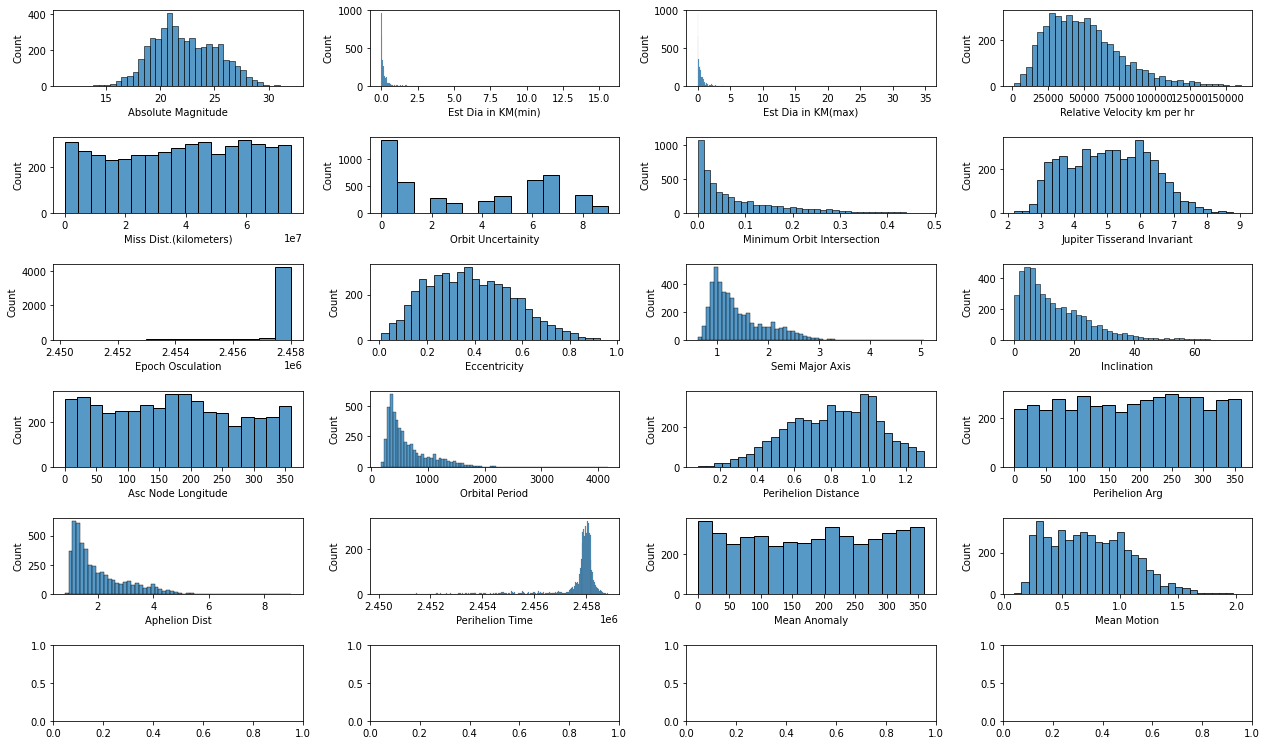

In [22]:
# Visualise series' distributions with histograms
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 11))
fig.tight_layout(pad=3.0)
for i in range(len(cols)):
    # Calculate in which matrix coordinate to draw the next plot
    matrix_coord = axes[i//num_cols, i%num_cols]
    sns.histplot(ax=matrix_coord, x=data[cols[i]])

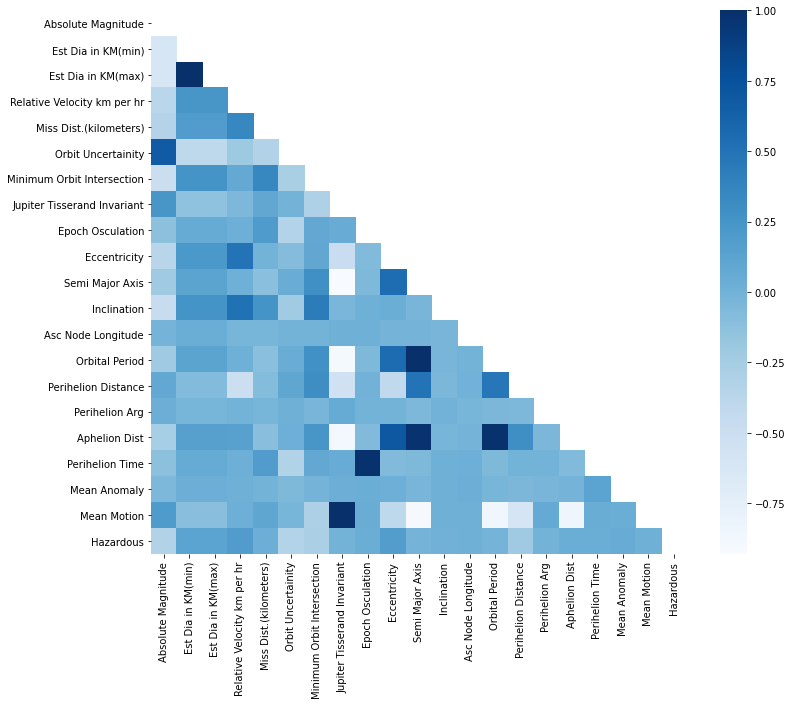

In [23]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
# Calculate correlation between features
cor = data.corr()
top_half_mask = np.zeros_like(cor)
top_half_mask[np.triu_indices_from(top_half_mask)] = True
sns.heatmap(cor, annot=False, cmap=plt.cm.Blues, mask=top_half_mask)
plt.show()

In [24]:
# ['Absolute Magnitude', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Relative Velocity km per hr', 
# 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 
# 'Orbit Uncertainity', 'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant', 'Epoch Osculation', 
# 'Eccentricity', 'Semi Major Axis', 'Inclination', 'Asc Node Longitude', 'Orbital Period', 'Perihelion Distance', 
# 'Perihelion Arg', 'Aphelion Dist', 'Perihelion Time', 'Mean Anomaly', 'Mean Motion', 'Hazardous']

#data = data.query(" (`Est Dia in KM(min)` < 0.5) or (`Est Dia in KM(max)` < 1.1) or (`Relative Velocity km per hr` < 10000) ")
#data.shape

In [25]:
#plt.scatter(y = data["Est Dia in KM(min)"], x=range(0, data.shape[0]))
#plt.show()

## Transform columns

In [26]:
label = ["Hazardous"]
# Remove the last column i.e. the label
features = keep_columns[:-1]

In [27]:
# Normalize numeric features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Indices of numeric features (column-wise)
numeric_features = list( range( len(features) ) )
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ]
)

# Build Model

## Select Train-Test sets

In [28]:
features = data[features].to_numpy()
label = data[label].to_numpy()
# 80-20 split for training and testing
x_train, x_test, y_train, y_test = train_test_split(
    features, 
    label, 
    test_size=0.1, 
    random_state=1, 
    shuffle=True
)

## Train model

In [29]:
# Create the model as pipeline that includes the pre-processing steps and the algorithm
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", tree.DecisionTreeClassifier())
])
# Train the model
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19])])),
                ('classifier', DecisionTreeClassifier())])

## Evaluate Model

In [30]:
# Make predictions for the test set
y_pred = pipeline.predict(x_test)

In [31]:
# Single function to calculate precision, recall and f1 score for each label class
# Returns a tuple of arrays, and so you need to calculate the mean of each array to get the final value for each metric
precision_recall_fscore_results = metrics.precision_recall_fscore_support(y_test, y_pred)

precision = round(precision_recall_fscore_results[0].mean() * 100, 2)
recall = round(precision_recall_fscore_results[1].mean() * 100, 2)
fscore = round(precision_recall_fscore_results[2].mean() * 100, 2)

accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)

In [32]:
print(f"Accuracy: {accuracy}%")
print(f"Precision: {precision}%")
print(f"Recall: {recall}%")
print(f"F1-Score: {fscore}%")

Accuracy: 99.57%
Precision: 99.3%
Recall: 99.3%
F1-Score: 99.3%
